In [1]:
from comet_ml import Experiment
from comet_ml import API
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import classification_report, PrecisionRecallDisplay, brier_score_loss
from sklearn.metrics import roc_curve, auc
import os 
import pickle
import seaborn as sn
import numpy as np
import pandas as pd

from utils import preprocess,transform

from matplotlib import pyplot as plt
from comet_api_key import comet_ml_key
import warnings
warnings.filterwarnings("ignore")

In [140]:
experiment = Experiment(
    api_key=comet_ml_key(),
    project_name="nhl-analytics",
    workspace="ift6758-22-team2",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-22-team2/nhl-analytics/1f7eaab900a340f6ad0521f1259b5929



##### Donwload Model from comet workspace

In [2]:
def download_model(workspace,model_name,version):
    if not os.path.exists('comet_models/'):
        os.mkdir('comet_models/')
    api = API(api_key=comet_ml_key())
    api.download_registry_model(workspace=workspace,registry_name=model_name, version=version,
    output_path='./comet_models', expand=True)

In [3]:
Model=['mlp-classifier-final','xgb-best-final','logreg-with-angle','logreg-with-distance','logreg-with-distance-and-angle']
for i in Model :
    download_model('ift6758-22-team2',i,'1.0.0')

COMET INFO: Downloading registry model 'mlp-classifier-final', version '1.0.0', stage None from workspace 'ift6758-22-team2'...
COMET INFO: Unzipping model to 'c:\\Users\\mayya\\OneDrive\\Desktop\\Res\\main\\Milestone2\\comet_models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'xgb-best-final', version '1.0.0', stage None from workspace 'ift6758-22-team2'...
COMET INFO: Unzipping model to 'c:\\Users\\mayya\\OneDrive\\Desktop\\Res\\main\\Milestone2\\comet_models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'logreg-with-angle', version '1.0.0', stage None from workspace 'ift6758-22-team2'...
COMET INFO: Unzipping model to 'c:\\Users\\mayya\\OneDrive\\Desktop\\Res\\main\\Milestone2\\comet_models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'logreg-with-distance', version '1.0.0', stage None from workspace 'ift6758-22-team2'...
COMET INFO: Unzipping model to 'c:\\Users\\mayya\\OneDrive\\Desktop\\Res\\main\\Milestone2\\comet_models' ...
COM

### Q1  Test on 2019/20 Regular Season Dataset

##### Load Dataset

In [4]:
df=pd.read_csv('./tidy_data/complete_dataset.csv',index_col=0)

In [5]:
df_test=df[(df['season']==20192020) & (df['gameType']=='R')]
df_test.head()

,index,gameID_eventID,game_period,dateTime,gameID,team,goal,x,y,shooter,...,distance_from_last_event,rebound,speed,time_since_powerplay_started,nbFriendly_non_goalie_skaters,nbOpposing_non_goalie_skaters,team_side,distanceNet_or_shotDistance,shot_angle_absolute,change_in_shot_angle
340145,340145,2019020001_10,1,2019-10-02T23:15:32Z,2019020001,Ottawa Senators,1,85.0,-1.0,Brady Tkachuk,...,85.005882,False,3.400235,0,5,5,left,4.123106,14.036243,0.0
340146,340146,2019020001_15,1,2019-10-02T23:18:23Z,2019020001,Toronto Maple Leafs,0,-32.0,-2.0,Morgan Rielly,...,29.274562,False,1.084243,35,5,4,right,57.035077,2.009554,0.0
340147,340147,2019020001_20,1,2019-10-02T23:20:45Z,2019020001,Ottawa Senators,0,63.0,-6.0,Dylan DeMelo,...,127.015747,False,9.072553,0,5,5,left,26.683328,12.994617,0.0
340148,340148,2019020001_21,1,2019-10-02T23:21:17Z,2019020001,Toronto Maple Leafs,0,-59.0,-20.0,Morgan Rielly,...,93.000000,False,15.500000,0,5,5,right,36.055513,33.690068,0.0
340149,340149,2019020001_24,1,2019-10-02T23:22:36Z,2019020001,Toronto Maple Leafs,0,-42.0,-29.0,Tyson Barrie,...,55.000000,False,9.166667,0,5,5,right,55.226805,31.675469,0.0


##### Load Model

In [6]:
mlp = pickle.load(open('./comet_models/MLP_classifier.sav','rb'))
xgb=pickle.load(open('./comet_models/xgb_best.sav','rb'))
logreg_dist=pickle.load(open('./comet_models/logreg_dist.sav','rb'))
logreg_angle=pickle.load(open('./comet_models/logreg_angle.sav','rb'))
logreg_dist_angle=pickle.load(open('./comet_models/logreg_dist_angle.sav','rb'))

##### Evaluate models

In [7]:
classifier_pipeline=[mlp,xgb,logreg_dist,logreg_angle,logreg_dist_angle]

In [20]:
Models_pred=[]
Models_proba=[]
best_model=[]
pipe_dict={0:'Mlp Classifier',1:'XGBoost classifier',2:'Logistic Regression(distance)',3:'Logistic Regression(angle)',4:'Logistic Regression(distance+angle)'}

#### MLP Classifier

In [9]:
##load Data
test_x=df_test[['change_in_shot_angle','shot_angle_absolute','distanceNet_or_shotDistance','nbOpposing_non_goalie_skaters',
'nbFriendly_non_goalie_skaters','time_since_powerplay_started','speed','rebound','distance_from_last_event','x','y','last_x','last_y'
]]
test_x['rebound'] = test_x['rebound']*1
test_y=df_test['goal']
test_x.head()

,change_in_shot_angle,shot_angle_absolute,distanceNet_or_shotDistance,nbOpposing_non_goalie_skaters,nbFriendly_non_goalie_skaters,time_since_powerplay_started,speed,rebound,distance_from_last_event,x,y,last_x,last_y
340145,0.0,14.036243,4.123106,5,5,0,3.400235,0,85.005882,85.0,-1.0,0.0,0.0
340146,0.0,2.009554,57.035077,4,5,35,1.084243,0,29.274562,-32.0,-2.0,-36.0,-31.0
340147,0.0,12.994617,26.683328,5,5,0,9.072553,0,127.015747,63.0,-6.0,-64.0,-4.0
340148,0.0,33.690068,36.055513,5,5,0,15.500000,0,93.000000,-59.0,-20.0,34.0,-20.0
340149,0.0,31.675469,55.226805,5,5,0,9.166667,0,55.000000,-42.0,-29.0,-86.0,4.0


In [21]:
# Metric
print(pipe_dict[0])
print(f'Test accuracy: {classifier_pipeline[0].score(test_x, test_y)}' )
best_model.append(classifier_pipeline[0].score(test_x, test_y))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[0].predict(test_x) 
Models_pred.append(y_pred_val)
Models_proba.append(classifier_pipeline[0].predict_proba(test_x))
print('Classification Report')
report = classification_report(test_y, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Mlp Classifier
Test accuracy: 0.905500093907566
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.909034,0.994912,0.950036,62505.0000
Goal,0.605948,0.072855,0.130070,6712.0000
accuracy,0.905500,0.905500,0.905500,0.9055
macro avg,0.757491,0.533883,0.540053,69217.0000
weighted avg,0.879643,0.905500,0.870524,69217.0000


#### XGBoost classifier

In [11]:
#preprocess data 
X_train, _, y_train, _ = preprocess(df)
df_train_xg = preprocess(df_test, split=False)
df_test_xg = transform(X_train, df_train_xg.loc[::,df_train_xg.columns!='goal'], y_train)
df_test_yg=df_test['goal']

dataset saved as <df_dataset.csv>
df_testset saved as <df_testset.csv>
dataset saved as <df_dataset.csv>
df_testset saved as <df_testset.csv>


In [22]:
# Metric
print(pipe_dict[1])
print(f'Test accuracy: {classifier_pipeline[1].score(df_test_xg,df_test_yg)}' )
best_model.append(classifier_pipeline[1].score(df_test_xg,df_test_yg))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[1].predict(df_test_xg) 
Models_pred.append(y_pred_val)
Models_proba.append(classifier_pipeline[1].predict_proba(df_test_xg))
print('Classification Report')
report = classification_report(df_test_yg, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

XGBoost classifier
Test accuracy: 0.9287024863834029
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.927407,0.999264,0.961995,62505.000000
Goal,0.975388,0.271603,0.424892,6712.000000
accuracy,0.928702,0.928702,0.928702,0.928702
macro avg,0.951397,0.635434,0.693444,69217.000000
weighted avg,0.932060,0.928702,0.909912,69217.000000


#### Logistic Regression with distance

In [13]:
#Preprocess data for logistic regression
df_train_logistic = df_test[['distanceNet_or_shotDistance', 'shot_angle_absolute','goal']]
df_train_logistic = df_train_logistic.dropna().reset_index(drop=True)
df_train_logistic

,distanceNet_or_shotDistance,shot_angle_absolute,goal
0,4.123106,14.036243,1
1,57.035077,2.009554,0
2,26.683328,12.994617,0
3,36.055513,33.690068,0
4,55.226805,31.675469,0
...,...,...,...
69211,23.537205,12.264774,0
69212,19.104973,6.009006,0
69213,24.020824,2.385944,0
69214,24.186773,7.125016,1


In [14]:
test_x_lrd=df_train_logistic['distanceNet_or_shotDistance'].to_numpy().reshape(-1, 1)
test_y_lrd=df_train_logistic['goal'].to_numpy().reshape(-1, 1)
test_x_lrd

array([[ 4.12310563],
       [57.03507693],
       [26.68332813],
       ...,
       [24.0208243 ],
       [24.18677324],
       [19.10497317]])

In [23]:
# Metric
print(pipe_dict[2])
print(f'Test accuracy: {classifier_pipeline[2].score(test_x_lrd, test_y_lrd)}' )
best_model.append(classifier_pipeline[2].score(test_x_lrd, test_y_lrd))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[2].predict(test_x_lrd) 
Models_pred.append(y_pred_val)
Models_proba.append(classifier_pipeline[2].predict_proba(test_x_lrd))
print('Classification Report')
report = classification_report(test_y_lrd, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Logistic Regression(distance)
Test accuracy: 0.9030282015718909
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.903028,1.000000,0.949043,62504.000000
Goal,0.000000,0.000000,0.000000,6712.000000
accuracy,0.903028,0.903028,0.903028,0.903028
macro avg,0.451514,0.500000,0.474522,69216.000000
weighted avg,0.815460,0.903028,0.857013,69216.000000


#### Logistic Regression with angle

In [16]:
test_x_lra=df_train_logistic['shot_angle_absolute'].to_numpy().reshape(-1, 1)
test_y_lra=df_train_logistic['goal'].to_numpy().reshape(-1, 1)
test_x_lra

array([[14.03624347],
       [ 2.00955381],
       [12.99461679],
       ...,
       [ 2.38594403],
       [ 7.12501635],
       [ 6.00900596]])

In [24]:
# Metric
print(pipe_dict[3])
print(f'Test accuracy: {classifier_pipeline[3].score(test_x_lra, test_y_lra)}' )
best_model.append(classifier_pipeline[3].score(test_x_lra, test_y_lra))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[3].predict(test_x_lra) 
Models_pred.append(y_pred_val)
Models_proba.append(classifier_pipeline[3].predict_proba(test_x_lra))
print('Classification Report')
report = classification_report(test_y_lrd, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Logistic Regression(angle)
Test accuracy: 0.9030282015718909
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.903028,1.000000,0.949043,62504.000000
Goal,0.000000,0.000000,0.000000,6712.000000
accuracy,0.903028,0.903028,0.903028,0.903028
macro avg,0.451514,0.500000,0.474522,69216.000000
weighted avg,0.815460,0.903028,0.857013,69216.000000


#### Logistic Regression with angle + distance

In [18]:
test_x_lrda=df_train_logistic[['distanceNet_or_shotDistance','shot_angle_absolute']]
test_y_lrda=df_train_logistic['goal']
test_x_lrda.head()

,distanceNet_or_shotDistance,shot_angle_absolute
0,4.123106,14.036243
1,57.035077,2.009554
2,26.683328,12.994617
3,36.055513,33.690068
4,55.226805,31.675469


In [25]:
# Metric
print(pipe_dict[4])
print(f'Test accuracy: {classifier_pipeline[4].score(test_x_lrda, test_y_lrda)}' )
best_model.append(classifier_pipeline[4].score(test_x_lrda, test_y_lrda))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[4].predict(test_x_lrda) 
Models_pred.append(y_pred_val)
Models_proba.append(classifier_pipeline[4].predict_proba(test_x_lrda))
print('Classification Report')
report = classification_report(test_y_lrd, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Logistic Regression(distance+angle)
Test accuracy: 0.9030282015718909
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.903028,1.000000,0.949043,62504.000000
Goal,0.000000,0.000000,0.000000,6712.000000
accuracy,0.903028,0.903028,0.903028,0.903028
macro avg,0.451514,0.500000,0.474522,69216.000000
weighted avg,0.815460,0.903028,0.857013,69216.000000


#### Best Classifier on 2019-2020 Regular season

In [26]:
best_classifier=best_model.index(max(best_model))
print('Classifier with best Accuracy : {}.'.format(pipe_dict[best_classifier]))  

Classifier with best Accuracy : XGBoost classifier.


##### Model performance Visualization

{'web': 'https://www.comet.com/api/image/download?imageId=b323ad4c66614085b35b7da4671bd0ef&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b323ad4c66614085b35b7da4671bd0ef&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': 'b323ad4c66614085b35b7da4671bd0ef'}

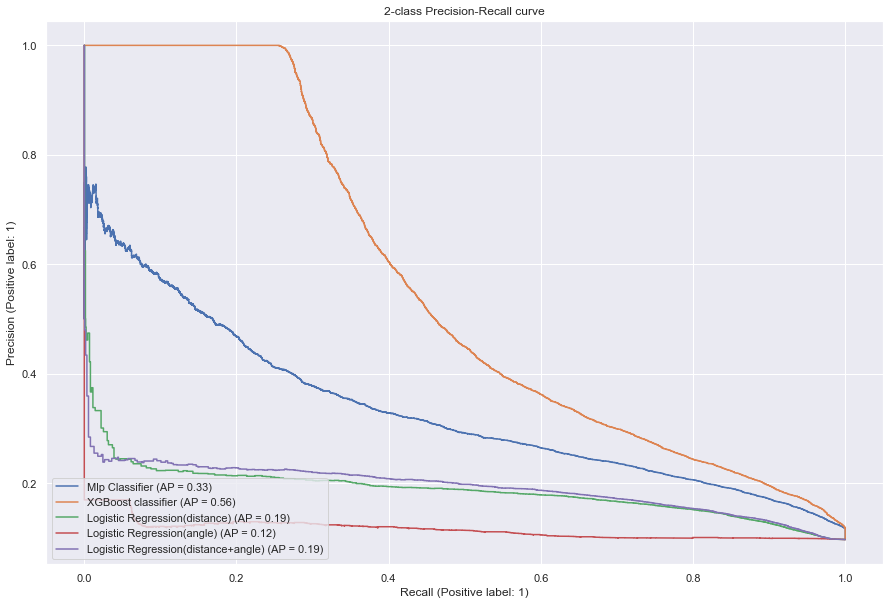

In [159]:
fig = plt.figure(figsize=(15, 10))
sn.set()
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[0],test_x,test_y, ax = plt.gca(),name = pipe_dict[0])   
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[1],df_test_xg,df_test_yg, ax = plt.gca(),name = pipe_dict[1])   
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[2],test_x_lrd,test_y_lrd, ax = plt.gca(),name = pipe_dict[2])  
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[3],test_x_lra,test_y_lra, ax = plt.gca(),name = pipe_dict[3])  
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[4],test_x_lrda,test_y_lrda, ax = plt.gca(),name = pipe_dict[4])  
display.ax_.set_title("2-class Precision-Recall curve")
experiment.log_figure(figure_name='Precision-Recall Curve Regular', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=f56e37f63ec049af998b6efa2119ffe3&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=f56e37f63ec049af998b6efa2119ffe3&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': 'f56e37f63ec049af998b6efa2119ffe3'}

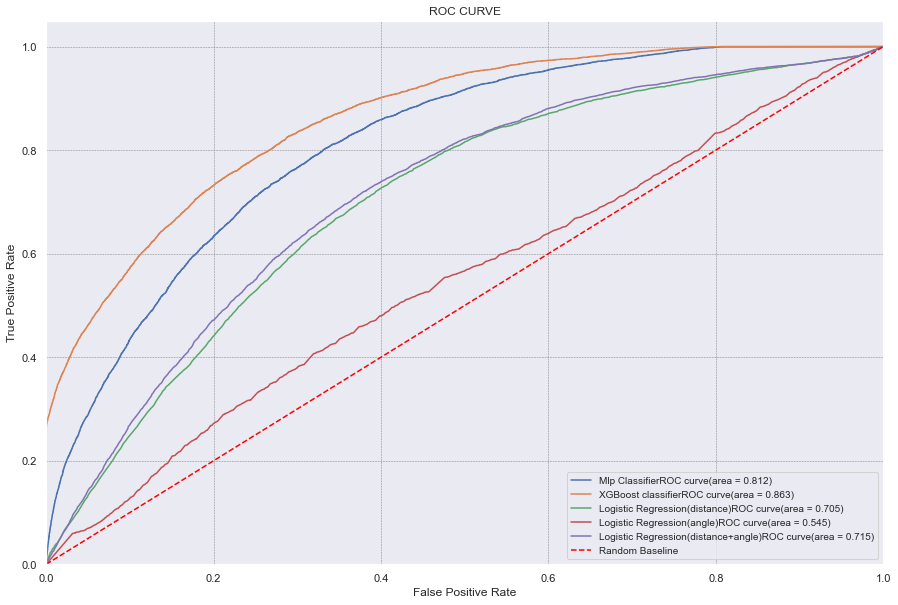

In [160]:

fig = plt.figure(figsize=(15, 10))

# Get FPR, TPR and AUC
fpr, tpr, _ = roc_curve(test_y,classifier_pipeline[0].predict_proba(test_x)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[0])+"ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(df_test_yg,classifier_pipeline[1].predict_proba(df_test_xg)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[1])+"ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(test_y_lrd,classifier_pipeline[2].predict_proba(test_x_lrd)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[2])+"ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(test_y_lra,classifier_pipeline[3].predict_proba(test_x_lra)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[3])+"ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(test_y_lrda,classifier_pipeline[4].predict_proba(test_x_lrda)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[4])+"ROC curve(area = %0.3f)" % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')   
experiment.log_figure(figure_name='ROC Curve Regular', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=fcc45ceaea2c4519a051661aedc1346c&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=fcc45ceaea2c4519a051661aedc1346c&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': 'fcc45ceaea2c4519a051661aedc1346c'}

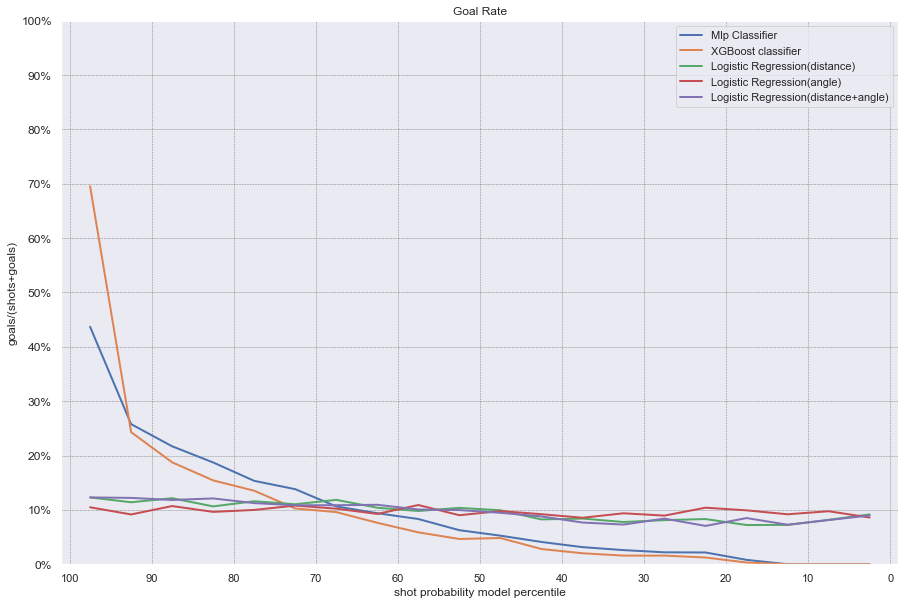

In [161]:
fig = plt.figure(figsize = (15,10))
for i,model in enumerate(classifier_pipeline):
    bins = list(np.arange(0, 105,  5))
    bin_centers = list(np.arange(2.5, 100,  5.0))
    df_prob = pd.DataFrame(list(zip(Models_pred[i] ,test_y,Models_proba[i][:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()
    df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
    df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
    df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
    df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
    df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()
    ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined, linewidth = 2,label=str(pipe_dict[i]))
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('goals/(shots+goals)')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.yticks(np.arange(0,1.1,.1))
    yvals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
    plt.xticks(np.arange(0,110,10))
plt.title(f"Goal Rate")    
experiment.log_figure(figure_name='Goal Rate Regular', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=65b30c667a7244d29557729c468f15ac&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=65b30c667a7244d29557729c468f15ac&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': '65b30c667a7244d29557729c468f15ac'}

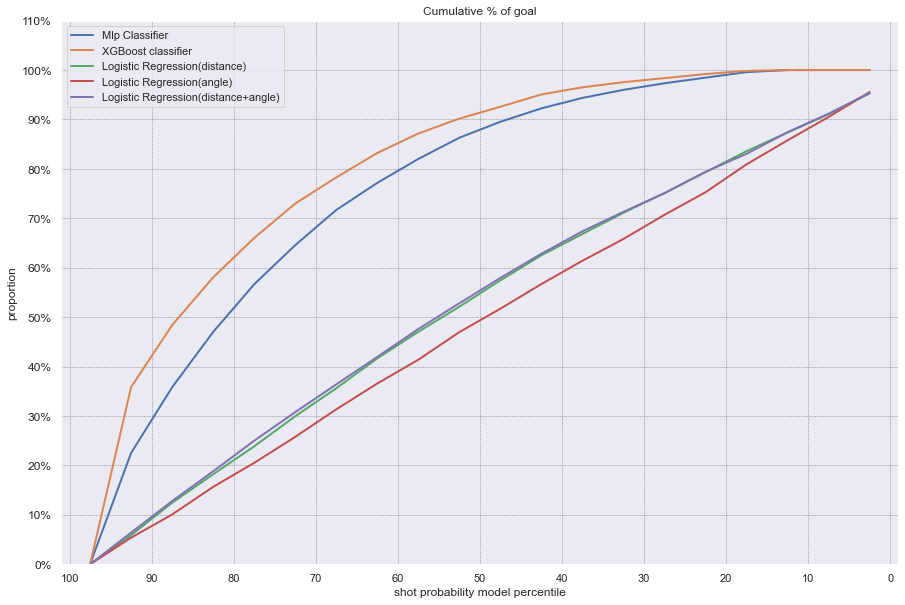

In [162]:

fig = plt.figure(figsize = (15,10))
for i,model in enumerate(classifier_pipeline):
    bins = list(np.arange(0, 105,  5))
    bin_centers = list(np.arange(2.5, 100,  5.0))
    df_prob = pd.DataFrame(list(zip(Models_pred[i] ,test_y,Models_proba[i][:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()
    df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
    df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
    df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
    df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
    df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()
    plt.title(f"Cumulative % of goal")
    ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined, label=str(pipe_dict[i]), linewidth = 2)
    plt.grid(color='gray', linestyle='--', linewidth=.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.yticks(np.arange(0,1.2,.1))
    yvals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
    plt.xticks(np.arange(0,110,10))

experiment.log_figure(figure_name=f'Cumulative % of goals Regular', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=947f41fd10304aae94bd5dcde8ab5e84&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=947f41fd10304aae94bd5dcde8ab5e84&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': '947f41fd10304aae94bd5dcde8ab5e84'}

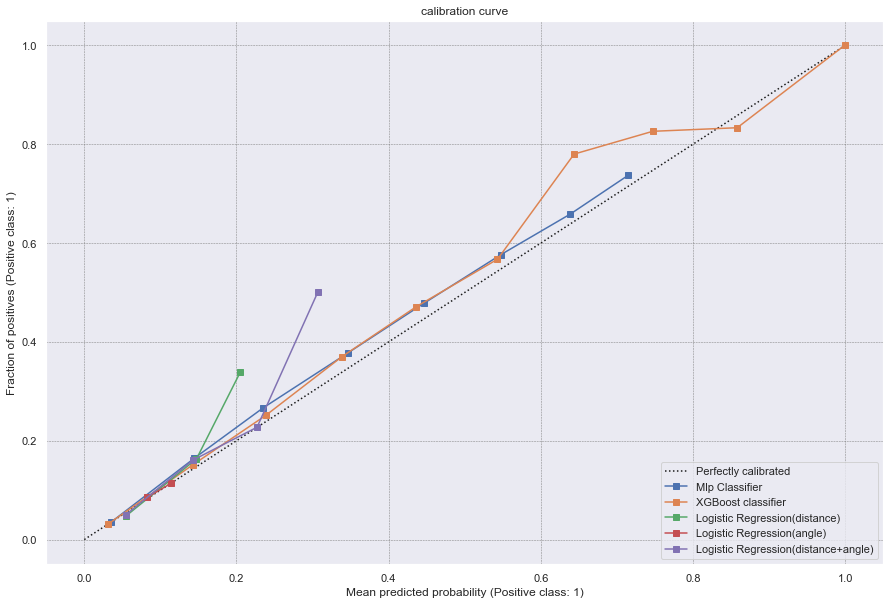

In [163]:
fig, ax = plt.subplots(figsize=(15, 10))

disp = CalibrationDisplay.from_predictions(test_y, Models_proba[0][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[0])
disp = CalibrationDisplay.from_predictions(df_test_yg, Models_proba[1][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[1])
disp = CalibrationDisplay.from_predictions(test_y_lrd, Models_proba[2][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[2])
disp = CalibrationDisplay.from_predictions(test_y_lra, Models_proba[3][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[3])
disp = CalibrationDisplay.from_predictions(test_y_lrda, Models_proba[4][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[4])

plt.grid(color='gray', linestyle='--', linewidth=.5)
plt.title(f"calibration curve")
experiment.log_figure(figure_name='Calibration plots Regular', step=None)

### Q2  Test on 2019/20 Playoffs Season Dataset

##### Load Playoffs dataset

In [27]:
df_pf=pd.read_csv('./tidy_data/complete_dataset.csv',index_col=0)

In [28]:
df_test_pf=df[(df['season']==20192020) & (df['gameType']=='P')]
df_test_pf.head()

,index,gameID_eventID,game_period,dateTime,gameID,team,goal,x,y,shooter,...,distance_from_last_event,rebound,speed,time_since_powerplay_started,nbFriendly_non_goalie_skaters,nbOpposing_non_goalie_skaters,team_side,distanceNet_or_shotDistance,shot_angle_absolute,change_in_shot_angle
332742,332742,2019030021_103,1,2020-08-02T00:24:50Z,2019030021,Montréal Canadiens,0,80.0,0.0,Brendan Gallagher,...,21.400935,False,1.783411,0,5,5,left,9.000000,0.000000,0.000000
332743,332743,2019030021_106,1,2020-08-02T00:25:42Z,2019030021,Pittsburgh Penguins,0,-61.0,-9.0,Evgeni Malkin,...,36.055513,False,6.009252,0,5,5,right,29.410882,17.818889,0.000000
332744,332744,2019030021_107,1,2020-08-02T00:25:48Z,2019030021,Pittsburgh Penguins,0,-64.0,-2.0,Evgeni Malkin,...,7.615773,True,1.269296,0,5,5,right,25.079872,4.573921,13.244968
332745,332745,2019030021_110,1,2020-08-02T00:27:10Z,2019030021,Pittsburgh Penguins,0,-51.0,-27.0,Brandon Tanev,...,101.597244,False,2.745871,0,5,5,right,46.615448,35.394796,0.000000
332746,332746,2019030021_111,1,2020-08-02T00:27:23Z,2019030021,Pittsburgh Penguins,0,-62.0,5.0,Kris Letang,...,33.837849,True,3.076168,0,5,5,right,27.459060,10.491477,134.113727


##### Evaluate Models

In [29]:
Models_predpf=[]
Models_probapf=[]
best_model_pf=[]

##### MLP Classifier

In [30]:
##load Data
train_x=df_test_pf[['change_in_shot_angle','shot_angle_absolute','distanceNet_or_shotDistance','nbOpposing_non_goalie_skaters',
'nbFriendly_non_goalie_skaters','time_since_powerplay_started','speed','rebound','distance_from_last_event','x','y','last_x','last_y'
]]
train_x['rebound'] = train_x['rebound']*1
train_y=df_test_pf['goal']
train_x.head()

,change_in_shot_angle,shot_angle_absolute,distanceNet_or_shotDistance,nbOpposing_non_goalie_skaters,nbFriendly_non_goalie_skaters,time_since_powerplay_started,speed,rebound,distance_from_last_event,x,y,last_x,last_y
332742,0.000000,0.000000,9.000000,5,5,0,1.783411,0,21.400935,80.0,0.0,97.0,-13.0
332743,0.000000,17.818889,29.410882,5,5,0,6.009252,0,36.055513,-61.0,-9.0,-49.0,25.0
332744,13.244968,4.573921,25.079872,5,5,0,1.269296,1,7.615773,-64.0,-2.0,-61.0,-9.0
332745,0.000000,35.394796,46.615448,5,5,0,2.745871,0,101.597244,-51.0,-27.0,50.0,-38.0
332746,134.113727,10.491477,27.459060,5,5,0,3.076168,1,33.837849,-62.0,5.0,-51.0,-27.0


In [31]:
# Metric
print(pipe_dict[0])
print(f'Test accuracy: {classifier_pipeline[0].score(train_x, train_y)}' )
best_model_pf.append(classifier_pipeline[0].score(train_x, train_y))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[0].predict(train_x) 
Models_predpf.append(y_pred_val)
Models_probapf.append(classifier_pipeline[0].predict_proba(train_x))
print('Classification Report')
report = classification_report(train_y, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Mlp Classifier
Test accuracy: 0.9139538025124949
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.919375,0.992745,0.954652,6754.000000
Goal,0.554545,0.093991,0.160738,649.000000
accuracy,0.913954,0.913954,0.913954,0.913954
macro avg,0.736960,0.543368,0.557695,7403.000000
weighted avg,0.887391,0.913954,0.885052,7403.000000


#### XGBoost classifier

In [32]:
#preprocess data 
X_train, _, y_train, _ = preprocess(df)
# df_train_xg = preprocess(df_test_pf, split=False)
df_test_xg = transform(X_train, df_train_xg.loc[::,df_train_xg.columns!='goal'], y_train)
df_test_yg=df_test['goal']

dataset saved as <df_dataset.csv>
df_testset saved as <df_testset.csv>


In [33]:
# Metric
print(pipe_dict[1])
print(f'Test accuracy: {classifier_pipeline[1].score(df_test_xg,df_test_yg)}' )
best_model_pf.append(classifier_pipeline[1].score(df_test_xg,df_test_yg))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[1].predict(df_test_xg) 
Models_predpf.append(y_pred_val)
Models_probapf.append(classifier_pipeline[1].predict_proba(df_test_xg))
print('Classification Report')
report = classification_report(df_test_yg, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

XGBoost classifier
Test accuracy: 0.9287024863834029
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.927407,0.999264,0.961995,62505.000000
Goal,0.975388,0.271603,0.424892,6712.000000
accuracy,0.928702,0.928702,0.928702,0.928702
macro avg,0.951397,0.635434,0.693444,69217.000000
weighted avg,0.932060,0.928702,0.909912,69217.000000


#### Logistic Regression with distance

In [34]:
#Preprocess data for logistic regression
df_train_logistic = df_test_pf[['distanceNet_or_shotDistance', 'shot_angle_absolute','goal']]
df_train_logistic.head()

,distanceNet_or_shotDistance,shot_angle_absolute,goal
332742,9.000000,0.000000,0
332743,29.410882,17.818889,0
332744,25.079872,4.573921,0
332745,46.615448,35.394796,0
332746,27.459060,10.491477,0


In [35]:
train_x_lrd=df_train_logistic['distanceNet_or_shotDistance'].to_numpy().reshape(-1, 1)
train_y_lrd=df_train_logistic['goal'].to_numpy().reshape(-1, 1)

In [36]:
# Metric
print(pipe_dict[2])
print(f'Test accuracy: {classifier_pipeline[2].score(train_x_lrd, train_y_lrd)}' )
best_model_pf.append(classifier_pipeline[2].score(train_x_lrd, train_y_lrd))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[2].predict(train_x_lrd) 
Models_predpf.append(y_pred_val)
Models_probapf.append(classifier_pipeline[2].predict_proba(train_x_lrd))
print('Classification Report')
report = classification_report(train_y_lrd, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Logistic Regression(distance)
Test accuracy: 0.912332838038633
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.912333,1.000000,0.954157,6754.000000
Goal,0.000000,0.000000,0.000000,649.000000
accuracy,0.912333,0.912333,0.912333,0.912333
macro avg,0.456166,0.500000,0.477078,7403.000000
weighted avg,0.832351,0.912333,0.870509,7403.000000


#### Logistic Regression with angle

In [37]:
train_x_lra=df_train_logistic['shot_angle_absolute'].to_numpy().reshape(-1, 1)
train_y_lra=df_train_logistic['goal'].to_numpy().reshape(-1, 1)

In [38]:
# Metric
print(pipe_dict[3])
print(f'Test accuracy: {classifier_pipeline[3].score(train_x_lra, train_y_lra)}' )
best_model_pf.append(classifier_pipeline[3].score(train_x_lra, train_y_lra))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[3].predict(train_x_lra) 
Models_predpf.append(y_pred_val)
Models_probapf.append(classifier_pipeline[3].predict_proba(train_x_lra))
print('Classification Report')
report = classification_report(train_y_lra, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Logistic Regression(angle)
Test accuracy: 0.912332838038633
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.912333,1.000000,0.954157,6754.000000
Goal,0.000000,0.000000,0.000000,649.000000
accuracy,0.912333,0.912333,0.912333,0.912333
macro avg,0.456166,0.500000,0.477078,7403.000000
weighted avg,0.832351,0.912333,0.870509,7403.000000


#### Logistic Regression with distance and angle

In [39]:
train_x_lrda=df_train_logistic[['distanceNet_or_shotDistance','shot_angle_absolute']]
train_y_lrda=df_train_logistic['goal']
train_x_lrda.head()

,distanceNet_or_shotDistance,shot_angle_absolute
332742,9.000000,0.000000
332743,29.410882,17.818889
332744,25.079872,4.573921
332745,46.615448,35.394796
332746,27.459060,10.491477


In [40]:
# Metric
print(pipe_dict[4])
print(f'Test accuracy: {classifier_pipeline[4].score(train_x_lrda, train_y_lrda)}' )
best_model_pf.append(classifier_pipeline[4].score(train_x_lrda, train_y_lrda))
is_Goal = ['Not_Goal', 'Goal']
y_pred_val = classifier_pipeline[4].predict(train_x_lrda) 
Models_predpf.append(y_pred_val)
Models_probapf.append(classifier_pipeline[4].predict_proba(train_x_lrda))
print('Classification Report')
report = classification_report(train_y_lrda, y_pred_val, output_dict=True,target_names=is_Goal)
results = pd.DataFrame(report).transpose()
results

Logistic Regression(distance+angle)
Test accuracy: 0.912332838038633
Classification Report


,precision,recall,f1-score,support
Not_Goal,0.912333,1.000000,0.954157,6754.000000
Goal,0.000000,0.000000,0.000000,649.000000
accuracy,0.912333,0.912333,0.912333,0.912333
macro avg,0.456166,0.500000,0.477078,7403.000000
weighted avg,0.832351,0.912333,0.870509,7403.000000


#### Best Classifier on 2019-2020 Playoff season data

In [43]:
best_classifier=best_model.index(max(best_model))
print('Classifier with best Accuracy : {}.'.format(pipe_dict[best_classifier]))  

Classifier with best Accuracy : XGBoost classifier.


##### Model performance Visualization


{'web': 'https://www.comet.com/api/image/download?imageId=6b49eadc9d4143469a9d6f991dd5f1fa&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6b49eadc9d4143469a9d6f991dd5f1fa&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': '6b49eadc9d4143469a9d6f991dd5f1fa'}

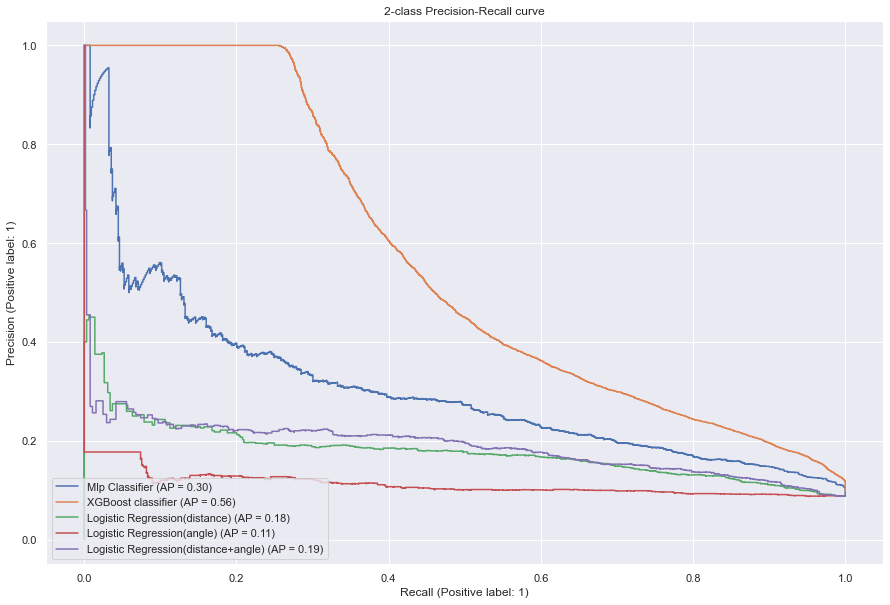

In [178]:
fig = plt.figure(figsize=(15, 10))
sn.set()
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[0],train_x,train_y, ax = plt.gca(),name = pipe_dict[0])   
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[1],df_test_xg,df_test_yg, ax = plt.gca(),name = pipe_dict[1]) 
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[2],train_x_lrd,train_y_lrd, ax = plt.gca(),name = pipe_dict[2])  
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[3],train_x_lra,train_y_lra, ax = plt.gca(),name = pipe_dict[3])  
display= PrecisionRecallDisplay.from_estimator(classifier_pipeline[4],train_x_lrda,train_y_lrda, ax = plt.gca(),name = pipe_dict[4])  
display.ax_.set_title("2-class Precision-Recall curve")
experiment.log_figure(figure_name='Precision-Recall Curve Playoff', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=42658cfe5897489790476968aaaa4d32&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=42658cfe5897489790476968aaaa4d32&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': '42658cfe5897489790476968aaaa4d32'}

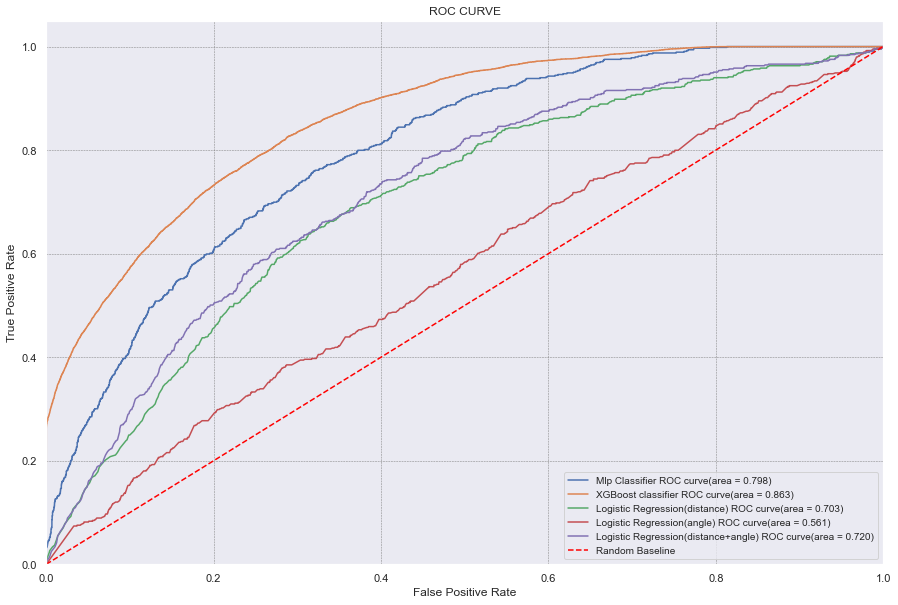

In [179]:
fig = plt.figure(figsize=(15, 10))

# Get FPR, TPR and AUC
fpr, tpr, _ = roc_curve(train_y,classifier_pipeline[0].predict_proba(train_x)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[0])+" ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(df_test_yg,classifier_pipeline[1].predict_proba(df_test_xg)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[1])+" ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(train_y_lrd,classifier_pipeline[2].predict_proba(train_x_lrd)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[2])+" ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(train_y_lra,classifier_pipeline[3].predict_proba(train_x_lra)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[3])+" ROC curve(area = %0.3f)" % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(train_y_lrda,classifier_pipeline[4].predict_proba(train_x_lrda)[:,1].ravel())
plt.plot(fpr, tpr, label=str(pipe_dict[4])+" ROC curve(area = %0.3f)" % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')   
experiment.log_figure(figure_name='ROC Curve Playoff', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=7f1615abf69849d9ba1036c726eabc7b&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7f1615abf69849d9ba1036c726eabc7b&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': '7f1615abf69849d9ba1036c726eabc7b'}

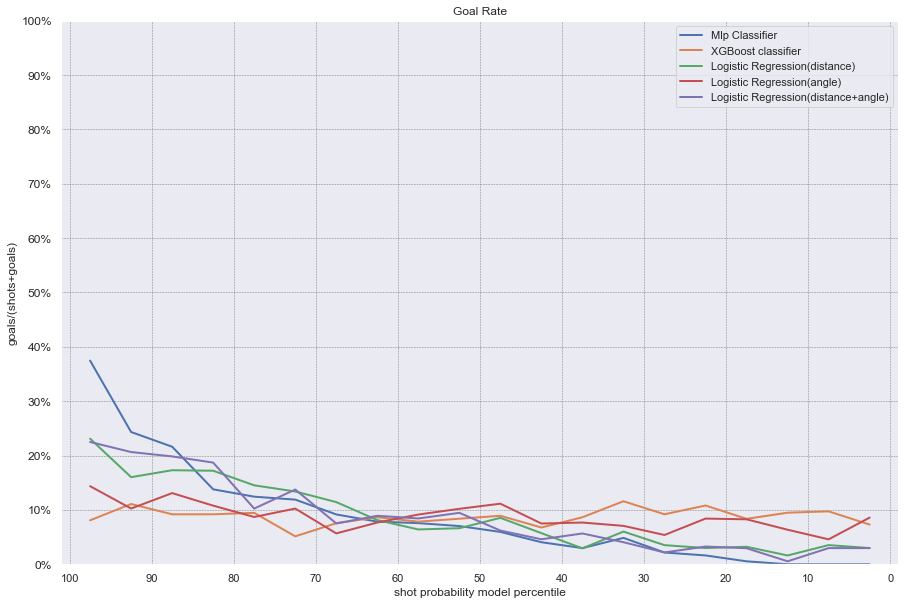

In [180]:
fig = plt.figure(figsize = (15,10))
for i,model in enumerate(classifier_pipeline):
    bins = list(np.arange(0, 105,  5))
    bin_centers = list(np.arange(2.5, 100,  5.0))
    df_prob = pd.DataFrame(list(zip(Models_predpf[i] ,train_y,Models_probapf[i][:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()
    df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
    df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
    df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
    df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
    df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()
    ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined, linewidth = 2,label=str(pipe_dict[i]))
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('goals/(shots+goals)')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.yticks(np.arange(0,1.1,.1))
    yvals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
    plt.xticks(np.arange(0,110,10))
plt.title(f"Goal Rate")    
experiment.log_figure(figure_name='Goal Rate Playoff', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=0226ded34e9845d880cbaaafbcef82bb&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0226ded34e9845d880cbaaafbcef82bb&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': '0226ded34e9845d880cbaaafbcef82bb'}

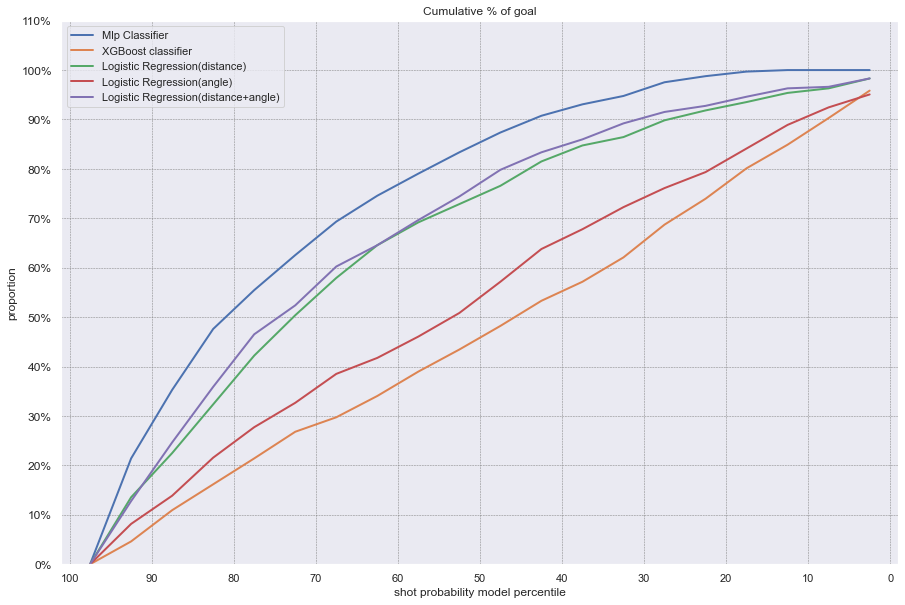

In [181]:
fig = plt.figure(figsize = (15,10))
for i,model in enumerate(classifier_pipeline):
    bins = list(np.arange(0, 105,  5))
    bin_centers = list(np.arange(2.5, 100,  5.0))
    df_prob = pd.DataFrame(list(zip(Models_predpf[i] ,train_y,Models_probapf[i][:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()
    df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
    df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
    df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
    df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
    df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()
    plt.title(f"Cumulative % of goal")
    ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined, label=str(pipe_dict[i]), linewidth = 2)
    plt.grid(color='gray', linestyle='--', linewidth=.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.yticks(np.arange(0,1.2,.1))
    yvals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
    plt.xticks(np.arange(0,110,10))

experiment.log_figure(figure_name=f'Cumulative % of goals Playoff', step=None) 

{'web': 'https://www.comet.com/api/image/download?imageId=915667b6a64a4d46acbbf5466bc436e3&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=915667b6a64a4d46acbbf5466bc436e3&experimentKey=1f7eaab900a340f6ad0521f1259b5929',
 'imageId': '915667b6a64a4d46acbbf5466bc436e3'}

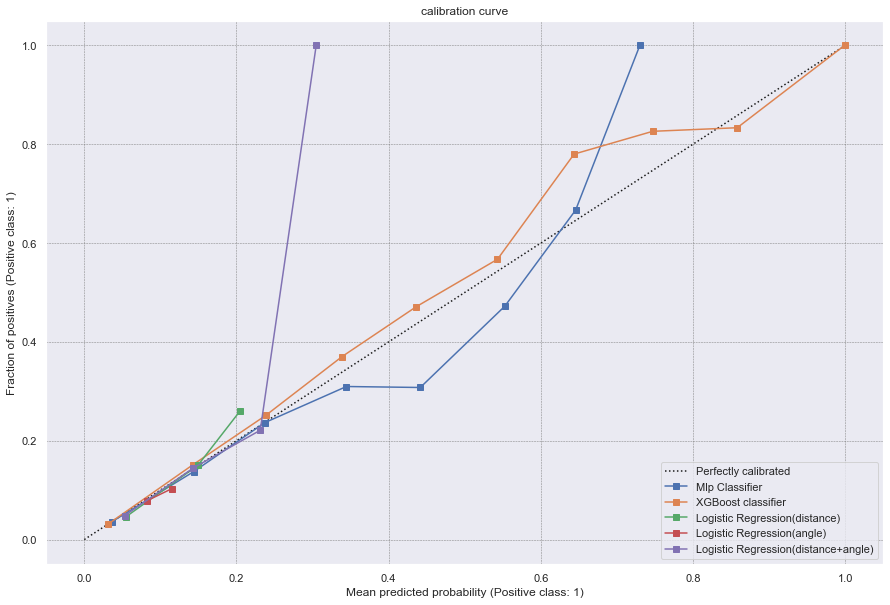

In [182]:
fig, ax = plt.subplots(figsize=(15, 10))

disp = CalibrationDisplay.from_predictions(train_y, Models_probapf[0][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[0])
disp = CalibrationDisplay.from_predictions(df_test_yg, Models_probapf[1][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[1])
disp = CalibrationDisplay.from_predictions(train_y_lrd, Models_probapf[2][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[2])
disp = CalibrationDisplay.from_predictions(train_y_lra, Models_probapf[3][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[3])
disp = CalibrationDisplay.from_predictions(train_y_lrda, Models_probapf[4][:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[4])

plt.grid(color='gray', linestyle='--', linewidth=.5)
plt.title(f"calibration curve")
experiment.log_figure(figure_name='Calibration plots Playoff', step=None)

In [183]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-22-team2/nhl-analytics/1f7eaab900a340f6ad0521f1259b5929
COMET INFO:   Parameters:
COMET INFO:     add_indicator  : False
COMET INFO:     categories     : auto
COMET INFO:     copy           : True
COMET INFO:     drop           : 1
COMET INFO:     dtype          : <class 'numpy.float64'>
COMET INFO:     fill_value     : 1
COMET INFO:     handle_unknown : ignore
COMET INFO:     max_categories : 1
COMET INFO:     min_frequency  : 1
COMET INFO:     missing_values : 27
COMET INFO:     sparse         : False
COMET INFO:     strategy       : most_frequent
COMET INFO:     verbose        : deprecated
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 10
COMET INFO:     filename          